In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

### Collect data

In [4]:
DATASET_ID = 'NA_BIRDS'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'nabirds.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,indv,indvi,species,key,audio,rate,spectrogram
0,0,0.465031,UNK,0,American crow,american_crow_0243,"[0.0030996066026771603, 0.002468325701773959, ...",32000,"[[0.0, 0.0, 0.0, 0.0, -0.0002469581, 0.0016932..."
0,0,0.430031,UNK,0,American crow,american_crow_0208,"[0.0004790301113228339, 0.0006568467900987811,...",32000,"[[0.0, 0.0, 0.0, 0.0, 0.0007178107, 0.00301318..."
0,0,0.405031,UNK,0,American crow,american_crow_0029,"[-0.0026205764913543265, -0.002008726604572815...",32000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [9]:
len(syllable_df)

2762

Text(0.5, 1.0, 'min')

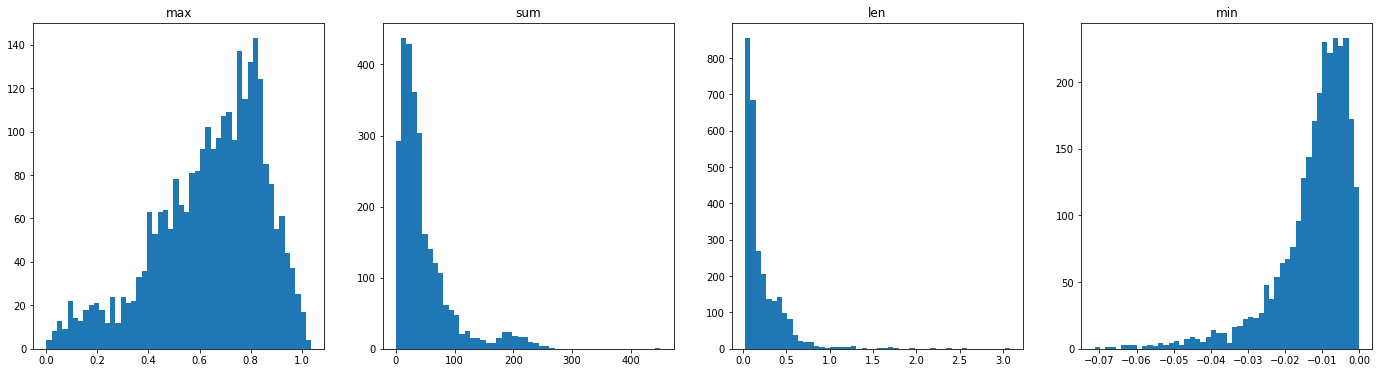

In [10]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[3].set_title('min')

### cluster

In [11]:
len(syllable_df)

2762

In [12]:
specs = list(syllable_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(2762, 928)

In [13]:
from cuml.manifold.umap import UMAP as cumlUMAP

cuml_umap = cumlUMAP()
embedding = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  after removing the cwd from sys.path.


In [14]:
np.shape(specs_flattened)

(2762, 928)

In [15]:
z  = embedding

In [16]:
z = np.vstack(z)

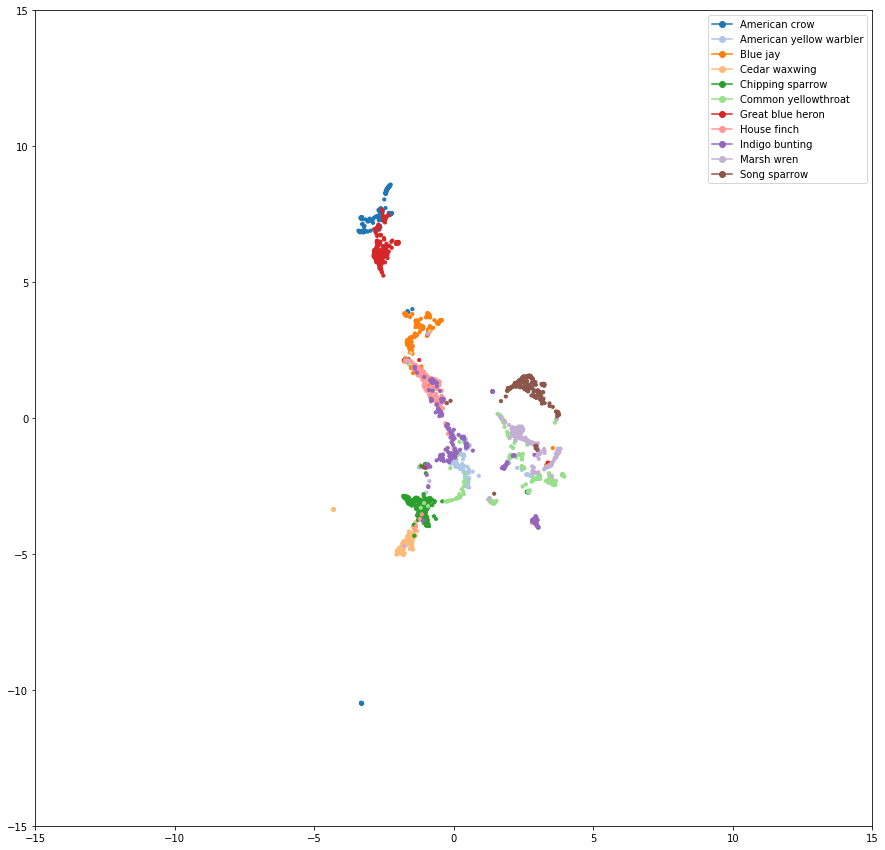

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=1, labels = syllable_df.species.values, s=10, ax = ax)
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
plt.show()

In [18]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [25]:
ensure_dir(FIGURE_DIR / 'discrete_umap' / 'species' )

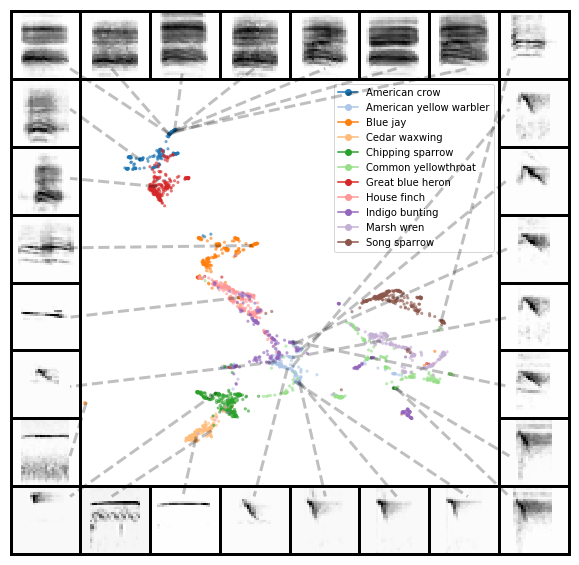

In [26]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': syllable_df.species.values,
        'alpha':0.5,
        's': 5,
        'show_legend': True,
        #"color_palette": 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(FIGURE_DIR / 'discrete_umap' / 'species' / 'na_birds', dpi=300, save_jpg=True, save_png=True)

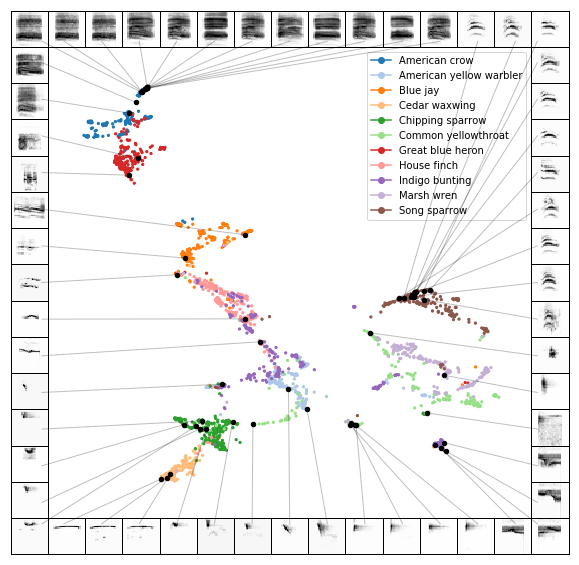

In [19]:
scatter_spec(
    z,
    specs,
    column_size=15,
    #x_range = [-12,7.5],
    #y_range = [-12,15],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': syllable_df.species.values,
        'alpha':1,
        's': 5,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
#save_fig(FIGURE_DIR / 'NA_birds', dpi=300, save_jpg=True, save_png=True)